# **CartoCell - inference workflow (Phase 5)**
___  
  
**CartoCell** is a deep learning-based image processing pipeline for the high-throughput segmentation of whole epithelial cysts acquired at low resolution with minimal human intervention. The official documentation of the workflow is in [CartoCell tutorial](https://biapy.readthedocs.io/en/latest/tutorials/cartocell.html). 

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/cartocell_pipeline.png' width='800px'/>
<figcaption><b>Figure 1</b>: CartoCell processing phases (from Andrés-San Román et al., 2022).</figcaption></center>
</figure>


**This notebook replicates CartoCell's Phase 5**, i.e., it allows the segmentation of 3D epithelial cysts using a deep learning model trained on a large dataset of low-resolution cysts (see Figure 1, Phase 4, model M2).

___


**CartoCell** relies on the [BiaPy library](https://github.com/danifranco/BiaPy), freely available in GitHub: https://github.com/danifranco/BiaPy

Please note that **CartoCell** is based on a publication. If you use it successfully for your research please be so kind to cite our work:
 
*''CartoCell, a high-throughput pipeline for accurate 3D image analysis, unveils cell morphology patterns in epithelial cysts''. Jesús A. Andrés-San Román, Carmen Gordillo-Vázquez, Daniel Franco-Barranco, Laura Morato, Antonio Tagua, Pablo Vicente-Munuera, Ana M. Palacios, María P. Gavilán, Valentina Annese, Pedro Gómez-Gálvez, Ignacio Arganda-Carreras, Luis M. Escudero. [under revision]*


___


## **Expected inputs and outputs**
___
**Inputs**

This notebook expects two folders as input:
* An input folder with **3D TIFF images** to be processed. A cyst per image is expected. 
* An output folder to store the segmentation results.

**Outputs**

If the execution is successful, the following files will be created for each input image:
* A **TIFF image** with the cell instances.



<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/cyst_sample.gif'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/cyst_instance_prediction.gif'/>
<figcaption><b>Figure 2</b>: CartoCell input samples. From left to rigth: 3D TIFF input image and the resulting TIFF image with the cell instances</figcaption></center>
</figure>






## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: use your local files and upload them to the notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files
from google.colab import files
!mkdir -p /content/input 
%cd /content/input
uploaded = files.upload()
%cd /content

### **Option 2: mount your Google Drive**
---
To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Option 3: use a few samples prepared by us**
---

In [ ]:
#@markdown ##Play the download our data samples
import os 

fname = "/content/test_x.zip "

!mkdir -p /content/input 

%cd /content 
if not os.path.exists(fname):
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    !gdown --id 1KKNBqIZ7NiWwxlRM8ctdgkx83JRNyBjq &> /dev/null
    %cd /content/input
    !unzip {fname}
%cd /content



/content
/content/input
Archive:  /content/test_x.zip
  inflating: 10d.1B.10.1.tif         
  inflating: 10d.1B.10.2.tif         
  inflating: 10d.1B.15.2.tif         
/content



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Paths to load input images and save output files**
___

If option 1 (uploading the folder) or option 3 (downloading our prepared data samples) was chosen, define data_path as '/content/input', and output_path as '/content/out'. Please make sure you donwload the results from the '/content/out' folder later!

If option 2 is chosen, introduce here the paths to your input files and to the folder where you want to store the results. E.g. '/content/gdrive/MyDrive/...'.

In case you have troubles finding the path to your folders, at the top left of this notebook you will find a small folder icon. Explore until you find the folders. There you can copy the folder path by right clicking and clicking "copy".

In [ ]:
#@markdown #####Path to images
data_path = '/content/input' #@param {type:"string"}

#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [1]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms                                                                           

# Clone the repo
%cd /content/ 
if not os.path.exists('BiaPy'):
    !git clone https://github.com/danifranco/BiaPy.git
    !git checkout a19de119e33d1ce6769e82aa592492ef33b00611 &> /dev/null
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    %cd /content/BiaPy
    
    # Install dependencies 
    !pip install git+https://github.com/aleju/imgaug.git &> /dev/null
    !pip install numpy_indexed yacs &> /dev/null

/content
Cloning into 'BiaPy'...
remote: Enumerating objects: 15088, done.
remote: Counting objects: 100% (1157/1157), done.
remote: Compressing objects: 100% (323/323), done.
remote: Total 15088 (delta 824), reused 1153 (delta 823), pack-reused 13931
Receiving objects: 100% (15088/15088), 816.20 MiB | 30.43 MiB/s, done.
Resolving deltas: 100% (8093/8093), done.
/content/BiaPy


## **Download pretrained model and apply 3D segmentation workflow (Phase 5)**


In [ ]:
#@markdown ##Play to download pretrained model M2 (from Phase 4)
import errno

job_name = "cartocell_inference"
# Download .yaml file and model weights 
%cd /content/
!gdown --id 1Z4SLO8ISeo0UmmYeyG-Dz93y7hoMZCR5 &> /dev/null
!gdown --id 1rnTls60MrndQHyyLgwwKr5UNZbjytnCF &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), data_path)
ids = sorted(next(os.walk(data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(data_path))


# Modify template according to defined variable paths
import fileinput

for line in fileinput.input("/content/"+str(job_name)+".yaml", inplace=True):
    if 'edit_test_path_here' in line:
        print('        PATH: {}'.format(data_path)) 
    else:
        print('{}'.format(line), end='')

import yaml
with open("/content/"+str(job_name)+".yaml", 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

/content


In [ ]:
#@markdown ##Play to pass images through the model
import os
import errno

# Run the code 
%cd '/content/BiaPy'
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0



/content/BiaPy
Date: 2022-11-22 08:16:07
Arguments: Namespace(config='/content/cartocell_inference.yaml', gpu='0', name='cartocell_inference', result_dir='/content/output', run_id=1)
Job: cartocell_inference_1
Python       : 3.7.15 (default, Oct 12 2022, 19:14:55) 
Keras        : 2.9.0
Tensorflow   : 2.9.2
Num GPUs Available:  1
Python process limited to 1 thread
Configuration details:
AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: True
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (0.1, 0.15)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRAST_EM_MODE: 3D
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: 

## **Visualize 3D instance segmentation results**


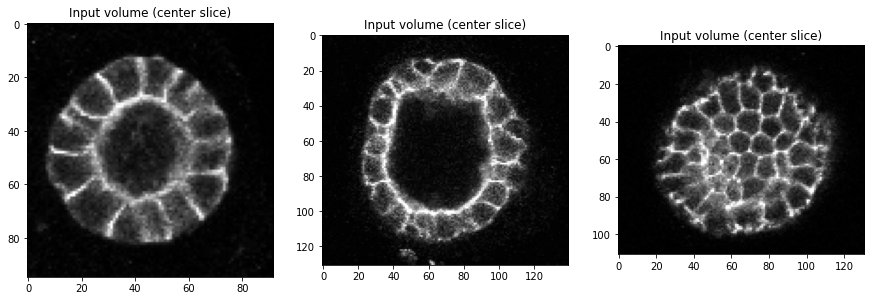

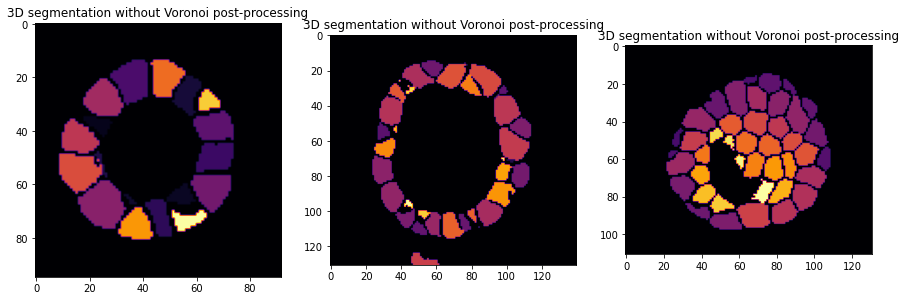

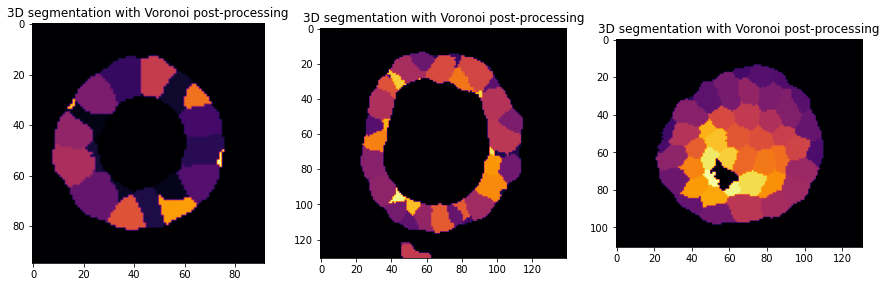

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

instance_results = os.path.join(final_results, "per_image_instances")
voronoi_results = os.path.join(final_results, "per_image_instances_voronoi")

#@markdown ##Play to visualize some results
from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly 
%matplotlib inline
import matplotlib
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids = sorted(next(os.walk(instance_results))[2])
ids_vor = sorted(next(os.walk(voronoi_results))[2])

# cmap = plt.cm.prism
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmaplist[0] = (0,0,0,1)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm', cmaplist, cmap.N)

samples_to_show = min(len(ids), 3)
choosen_images = np.random.choice(len(ids), samples_to_show, replace=False) 
seed(1)

test_samples = []
test_sample_preds = []
test_sample_vor = []

for i in range(len(choosen_images)):
    aux = imread(os.path.join(data_path, ids[choosen_images[i]]))
    sl = int(len(aux)/2)
    test_samples.append(aux[sl])
    aux = imread(os.path.join(instance_results, ids[choosen_images[i]]))[sl].astype(np.uint64)
    if np.max(aux)**4 < np.iinfo(aux.dtype).max: aux = aux**4
    test_sample_preds.append(aux)
    aux = imread(os.path.join(voronoi_results, ids_vor[choosen_images[i]]))[sl].astype(np.uint64)
    if np.max(aux)**4 < np.iinfo(aux.dtype).max: aux = aux**4
    test_sample_vor.append(aux)

# Show predicted images
for i in range(3):
    plt.figure(figsize=(15,15))
    for j in range(samples_to_show):
        plt.subplot(i+1, 3, j+1)
        if i == 0:
            plt.title("Input volume (center slice)")
            plt.imshow(test_samples[j], cmap='gray')          
        elif i == 1:
            plt.title("3D segmentation without Voronoi post-processing")
            plt.imshow(test_sample_preds[j], cmap="inferno")        
        else:
            plt.title("3D segmentation with Voronoi post-processing")
            plt.imshow(test_sample_vor[j], cmap="inferno")
    plt.show()


In [ ]:
#@markdown ###Play to display the path to the output files (one 3D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

instance_results = os.path.join(final_results, "per_image_instances")
voronoi_results = os.path.join(final_results, "per_image_instances_voronoi")

peak_dir = os.path.join(output_path, str(job_name)+'/results/'+str(job_name)+'_1/per_image_local_max_check')
print("Output files in {}".format(instance_results))
print("Voronoi applied output files in {}".format(voronoi_results))

Output files in /content/output/cartocell_inference/results/cartocell_inference_1/per_image_instances
Voronoi applied output files in /content/output/cartocell_inference/results/cartocell_inference_1/per_image_instances_voronoi
